In [ ]:
# default_exp utils.data

# Data Utility
> Functions for Data Downloading , Loading Images

In [ ]:
#hide
from nbdev.showdoc import *
from nbdev.export import *

In [ ]:
# export
import os
import cv2
from PIL import Image
from pathlib import Path

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from fastcore.all import ifnone, delegates

from torchvision.datasets.utils import download_and_extract_archive
from torchvision.datasets.folder import IMG_EXTENSIONS

from lightning_cv.utils.common import get_default_logger

In [ ]:
# export
logger = get_default_logger()

In [ ]:
# export
# copy from : https://github.com/fastai/fastai/blob/master/nbs/04_data.external.ipynb
# a thin wrapper over the original fastai.URLs
class Urls:
    "Global constants for dataset and model URLs."
    LOCAL_PATH = os.path.abspath(str(Path.cwd() / "data"))
    DOGS = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
    BEES = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

download a data from links in `Urls`

In [ ]:
# export
@delegates(download_and_extract_archive)
def download_data(url: str, data_path: str = None, **kwargs):
    "downloads and extracts the data at `Urls.LOCAL_PATH` if datapath is None"
    data_path = ifnone(data_path, Urls.LOCAL_PATH)
    os.makedirs(os.path.abspath(Urls.LOCAL_PATH), exist_ok=True)
    download_and_extract_archive(url, os.path.abspath(Urls.LOCAL_PATH), **kwargs)
    logger.info(f"Data downloaded to {Path(data_path)}")

In [ ]:
#hide
from nbdev.imports import Config as NbdevConfig
import matplotlib.pyplot as plt

nbdev_path = str(NbdevConfig().path("nbs_path")/'data')
nbdev_path

'/Users/ayushman/Desktop/lightning_cv/nbs/data'

In [ ]:
# hide
download_data(Urls.DOGS, data_path=nbdev_path)

0it [00:00, ?it/s]Downloading https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip to /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip
100%|█████████▉| 68599808/68606236 [00:39<00:00, 2010167.50it/s]Extracting /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip to /Users/ayushman/Desktop/lightning_cv/nbs/data
INFO:__main__:Data downloaded to /Users/ayushman/Desktop/lightning_cv/nbs/data


Load an Image's using PIL - 

In [ ]:
# hide
data  = Path(nbdev_path)/"cats_and_dogs_filtered/train"
image = data/"dogs/dog.0.jpg"

In [ ]:
# export
def pil_loader(path) -> Image.Image:
    "loads an image using PIL, mainly used for torchvision transformations"
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

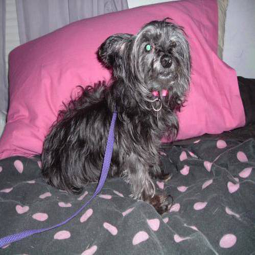

In [ ]:
im = pil_loader(image)
im.resize((255,255))

In [ ]:
# export
def cv2_loader(path) -> Image.Image:
    "loads an image using cv2, mainly used for albumentations transformations"
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

68608000it [00:47, 1453106.25it/s]                              


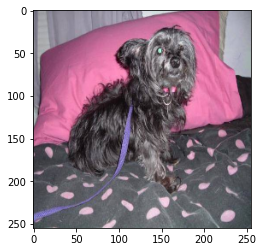

In [ ]:
im = cv2_loader(str(image))
im = cv2.resize(im, (255,255))
plt.imshow(im);

# Utilities for Pandas
> Set of utility functions for working with Image data and pandas

In [ ]:
#export
def folder2df(folder: str, extension: list = None, shuffle: bool = False):
    "parses all the images in a folder into a pandas dataframe."
    extensions = ifnone(extension, IMG_EXTENSIONS)
    
    image_list  = []
    target_list = []
    
    for f in os.listdir(folder):
        curr_path = os.path.join(folder, f)
        if os.path.isdir(curr_path):
            for image in os.listdir(curr_path):
                image_path = os.path.join(curr_path, image)
                image_tgt  = f
                if image_path.lower().endswith(extensions):
                    image_list.append(image_path)
                    target_list.append(image_tgt)
    
    logger.info(f"Found {len(image_list)} files belonging to {len(set(target_list))} classes.")
    dataframe = pd.DataFrame()
    dataframe["image_id"] = image_list
    dataframe["target"]   = target_list
    if shuffle: dataframe = dataframe.sample(frac=1).reset_index(inplace=False, drop=True)
    return dataframe

The folder stucture must be as follows - 
```
folder
|- class1
| |- image1
| |- image2
| |- image3
...
|- class2
| |- image1
| |- image2
| |- image3
|- class2
| |- image1
| |- image2
| |- image3
...
...
```

the `classes` in the folder will be given as `targets` and path of `image` will be stored in `image_id`

In [ ]:
# hide
df = folder2df(data, shuffle=True)
df.head()

INFO:__main__:Found 2000 files belonging to 2 classes.


,image_id,target
0,/Users/ayushman/Desktop/lightning_cv/nbs/data/...,cats
1,/Users/ayushman/Desktop/lightning_cv/nbs/data/...,cats
2,/Users/ayushman/Desktop/lightning_cv/nbs/data/...,dogs
3,/Users/ayushman/Desktop/lightning_cv/nbs/data/...,dogs
4,/Users/ayushman/Desktop/lightning_cv/nbs/data/...,dogs


In [ ]:
# export
@delegates(StratifiedKFold)
def stratify_df(df: pd.DataFrame, y: str = None, fold_col: str = None, shuffle: bool = False, **kwargs):
    """makes stratified folds in `df`. The Id of the OOF Validation
    fold will be inserted in `fold_col`. `y` is the name of the column to
    the dependent variable.
    """
    # preserve the original copy of the dataframe
    data = df.copy()
    skf  = StratifiedKFold(**kwargs)
    fold_col = ifnone(fold_col, "kfold")

    ys = data[y]
    data[fold_col] = -1

    for i, (train_index, test_index) in enumerate(skf.split(X=data, y=ys)):
        data.loc[test_index, "kfold"] = i
        
    if shuffle:  data = data.sample(frac=1).reset_index(drop=True)
    return data

In [ ]:
# hide
df1 = stratify_df(df, y="target", shuffle=True)
df1.head()

,image_id,target,kfold
0,/Users/ayushman/Desktop/lightning_cv/nbs/data/...,dogs,3
1,/Users/ayushman/Desktop/lightning_cv/nbs/data/...,dogs,4
2,/Users/ayushman/Desktop/lightning_cv/nbs/data/...,dogs,0
3,/Users/ayushman/Desktop/lightning_cv/nbs/data/...,cats,1
4,/Users/ayushman/Desktop/lightning_cv/nbs/data/...,cats,1


In [ ]:
# hide
notebook2script()

Converted 00_utils.common.ipynb.
Converted 00_utils.data.ipynb.
Converted index.ipynb.
